# CW05 - GUI paper exploration 5 - 50 parallel posteriors and momentum networks

Optional: We show here momentum networks for just 50 parallel posteriors. There could be instead examples for, e.g. image analysis, that are more interesting.

In [41]:
# Makes it easier to debug
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [42]:
import numpy as np
import pylab as plt
from scipy.linalg import inv
from scipy import stats
import scipy
import torch

In [110]:
import dynesty
import swyft

## Workflow: ZoomTask

In [111]:
class ZoomTask:
    def __init__(self, sim_or_store, prior, target_obs, partition = None, simhook = None, init_bound = None):
        if not isinstance(sim_or_store, swyft.Simulator):
            self.store = sim_or_store
        else:
            self.store = swyft.MemoryStore(sim)
        
        if partition is None:
            self.partition = list(range(len(self.store.pnames)))
        else:
            self.partition = partition
            
        self.prior = prior
        self.simhook = simhook
        self.target_obs = target_obs
        
        self.init_bound = init_bound
        self.last_bound = None
        self.history = []
        
    def run(self, rounds = 10, N = 10000, train_args = {}, head = None):
        for i in range(rounds):
            self.round(N = N, train_args = train_args, head = head)
        
    def round(self, N, train_args = {}, head = None):
        bound = self.init_bound if self.history == [] else self.history[-1][1]
        
        self.store.add(N, self.prior, bound = bound)
        self.store.simulate()
        dataset = swyft.Dataset(N, self.prior, self.store, simhook = self.simhook, bound = bound)
        post = swyft.Posteriors(dataset)
        post.add(self.partition, device='cuda', head = head, tail_args = dict(p=0.2, hidden_layers = [512, 512]))
        post.train(self.partition, **train_args)
        bound = post.truncate(self.partition, self.target_obs)
        
        self.history.append([post, bound])

## Model

In [388]:
N = 50  # Number of data bins
SIGMA = 0.01  # Measurement uncertainty

In [389]:
# Noise-free model

def model(v):
    return dict(x = v)

# Noise model
def noise(sim, v):
    #print(sim)
    noise = np.random.randn(N)*SIGMA
    return dict(x = sim['x'] + noise)

In [390]:
v0 = np.zeros(N)
obs0 = noise(model(v0), v0)

### Zoom in

In [391]:
sim = swyft.Simulator(model, N, dict(x=(N,)))
prior = swyft.Prior(lambda u: u, N)

In [392]:
NTRAIN = 1000

In [393]:
store = swyft.MemoryStore(sim)
store.add(NTRAIN, prior)
store.simulate()

Creating new store.
Store: Adding 986 new samples to simulator store.


In [394]:
dataset = swyft.Dataset(NTRAIN, prior, store, simhook = noise)

In [395]:
from swyft.networks.module import Module
from typing import Sequence
from swyft.networks.tail import _get_z_shape, _combine
from swyft.networks.normalization import OnlineNormalizationLayer
from swyft.networks.linear import LinearWithChannel
from torch import nn
from swyft.types import ObsType, SimShapeType

In [396]:
class DefaultHead(Module):
    """Default head network.

    Args:
        sim_shapes: Shape of the simulation data
        online_norm: Perform online normalization of the inputs

    .. note::
        The default head network requires that all simulation components are
        1-dim.  They will be simply concatenated into a single (potentially
        very large) feature vector.  `DefaultHead` should only be used for very
        low-dimensional data.  Almost always custom implementations will lead
        to better results.
    """

    def __init__(self, sim_shapes: SimShapeType, online_norm: bool = True) -> None:
        super().__init__(sim_shapes=sim_shapes, online_norm=online_norm)
        if not all(np.array([len(v) for v in sim_shapes.values()]) == 1):
            raise ValueError(
                "DefaultHead only supports 1-dim data. Please supply custom head network."
            )

        self.n_features = sum([v[0] for k, v in sim_shapes.items()])

        if online_norm:
            self.onl_f = OnlineNormalizationLayer(torch.Size([self.n_features]))
        else:
            self.onl_f = identity

    def forward(self, sim: ObsType) -> torch.Tensor:
        """Forward pass default head network. Concatenate.

        Args:
            sim: Dictionary of tensors with shape (n_batch, m_i)

        Returns:
            f: Feature vectors with shape (n_batch, M), with M = sum_i m_i
        """
        f = torch.cat([value for _, value in sorted(sim.items())], dim=-1)
        #f = self.onl_f(f)
        return f


In [412]:
class DefaultTail(Module):
    def __init__(
        self,
        n_features: int,
        marginals,
        hidden_layers: Sequence[int] = [256, 256, 256],
        p: float = 0.0,
        online_norm: bool = True,
        param_transform=None,
        tail_features: bool = False,
        n_tail_features: int = 2,
    ):
        """Default tail network.

        Args:
            n_features: Length of feature vector.
            marginals: List of marginals to learn.
            hidden_layers: Hidden layer size
            p: Dropout
            online_norm: Online normalization of parameters.
            param_transform: Perform optional parameter transform.
            tail_features: Use tail features.
            n_tail_features: Additional feature extractor network, number of features.

        .. note::
            We find that the default settings for the tail network typically
            give reasonable results, and are almost always enough.  Tuning
            makes only sense when the head network is already close-to optimal.
        """
        super().__init__(
            n_features,
            marginals,
            n_tail_features=n_tail_features,
            p=p,
            hidden_layers=hidden_layers,
            online_norm=online_norm,
            param_transform=param_transform,
            tail_features=tail_features,
        )
       
        self.logA = nn.Parameter(torch.zeros(N))
        self.S = nn.Parameter(torch.zeros(N))
        self.a = nn.Parameter(torch.ones(N))
        self.b = nn.Parameter(torch.zeros(N))

    def forward(self, f: torch.Tensor, params) -> torch.Tensor:  # TODO Christoph typing
        """Forward pass tail network.  Can handle one batch dimension.

        Args:
            f (tensor): feature vectors with shape (n_batch, n_features)
            params (dict): parameter dictionary, with parameter shape (n_batch,)

        Returns:
            lnL (tensor): lnL ratio with shape (n_batch, len(marginals))
        """
        #print(f)
        #print(params)
        #qwerty
        A = torch.exp(self.logA)
        r = -A*((f*self.a + self.b) - params)**2 - self.S
        #r = -A*(f - params)**2 - self.S
        return r
        print(f)
        print(params)
        # Feature compressors independent per channel
        #print(f.shape)
        f = f.unsqueeze(1).repeat(
            1, self.n_channels, 1
        )  # (n_batch, n_channels, n_features)
        #print(f.shape)
        
        # Channeled density estimator
        #print(params.shape)
        z = _combine(params, self.marginals)
        #print(z.shape)
        z = self.onl_z(z)

        x = torch.cat([f, z], -1)
        x = self.ratio_estimator(x)
        x = x.squeeze(-1)
        print(x)
        
        return x

In [413]:
class D(swyft.Dataset):
    def __init__(self, *args, **kwargs):
        super(D, self).__init__(*args, **kwargs)
        self.x = torch.rand(NTRAIN, N)
        self.p = torch.rand(NTRAIN, N)
    
    def __getitem__(self, i):
        return dict(x = self.x[i]), self.p[i], self.p[i]
    
dataset2 = D(NTRAIN, prior, store, simhook = noise)

In [414]:
post = swyft.Posteriors(dataset)
partition = range(N)
post.add(partition, device='cuda', tail_args = dict(p=0.2, hidden_layers = [512, 512]), head = DefaultHead, tail = DefaultTail)

In [415]:
def func():
    post.train(partition, max_epochs = 30, scheduler_args = dict(patience = 1, factor = 0.5), early_stopping_patience = 10, 
           batch_size = 128, optimizer_args = dict(lr = 0.1))
#%prun func()
func()

Training: lr=0.025, Epoch=30, VL=13.25


In [416]:
#post._ratios[((0,),(1,),(2,),(3,))].tail.logA

In [417]:
v0 = np.zeros(N) + 0.5
obs0 = noise(model(v0), v0)
samples = post.sample(100000, obs0)

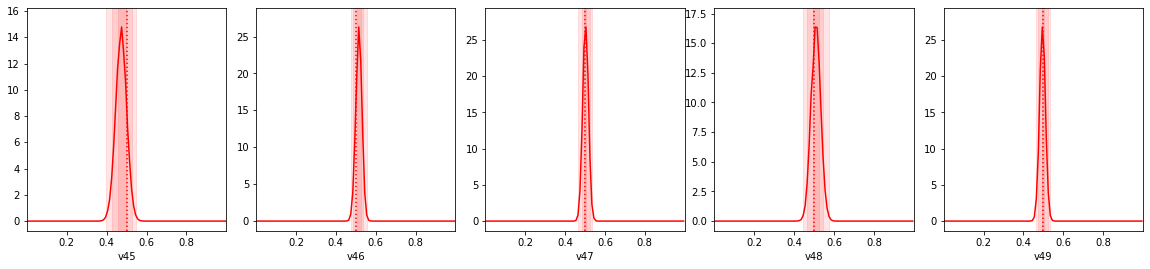

In [418]:
fig, diag = swyft.plot_1d(samples, range(45, 50), bins = 100, figsize=(20, 4), truth = v0, color='r', contours = True)